In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import re
import os
import ast
import nltk

In [6]:
filename_template = '/Users/ff/results_20200303/slurm-{0}.out'
target_template = '/Users/ff/dev/mathematics_dataset-v1.0/{0}-split'

jobids = ['extrapolate','interpolate']
targetids = jobids

In [7]:
def get_files(lines, regex, end=False):
    # we have these lines
    # filename
    # [2020-03-03 09:16:02,784 INFO] Translating shard 0.
    # ....
    # PRED AVG SCORE:
    files = []
    for i,line in enumerate(lines):
        match = re.findall(regex, line)
        if match:
            if end:
                filename = lines[i].strip()            
                files.append((filename, i))
            else:
                filename = lines[i-1].strip()
                files.append((filename, i-1))
    return files

In [8]:
def split_files(raw_lines, filenames_info):
    files = {}
    for i,f in enumerate(filenames_info):
        print(f[0])
        filename = f[0]
        start_line = f[1]
        end_line = f[3]
        
        file_ = raw_lines[start_line:end_line]
        files[i] = (file_)
    return files

In [9]:
class Result:
    def __init__(self, string, prediction, prob, target):
        self.string = string
        self.prediction = prediction
        self.prob = prob
        self.target = target
    
    def __str__(self):
        return (f'String: {self.string}\n\
                 Target: {self.target}\n\
                 Prediction: {self.prediction}\n\
                 Likelihood: {self.prob}')
    
def parse_single_result(string, pred, prob, target):
    string_ = re.sub(r'SENT [0-9]*:\ ', '', string)
    string_ = ast.literal_eval(string_)
    string = "".join(str(x) for x in string_).replace('_',' ')
    
    pred_ = re.sub(r'PRED [0-9]*:\ ', '', pred)
    pred = "".join(str(x) for x in pred_).strip().replace('_',' ')
    
    prob_ = re.sub(r'PRED SCORE:\ ', '', prob)
    prob = float(prob_)
    
    return Result(string, pred, prob, target)
    
def parse_file_results(raw_lines, targets):
    filename = raw_lines[0].strip()
    _ = raw_lines[1]
    res = [line for line in raw_lines[2:] if line != '\n']
    
    if len(res) % 3 != 0:
        print('Error', filename)
        return
    
    results = []
    for i in range(0, len(res), 3):
        string = res[i]
        prediction = res[i+1]
        prob = res[i+2]
        target = targets[i//3]
        results.append(parse_single_result(string, prediction, prob, target))
    return filename, results

In [10]:
def extract_targets(tasks, targetid):
    targets = {}
    for key in sorted(tasks.keys()):
        task_name = tasks[key][0].strip()
        task_name = task_name.replace('_src_test.txt','')
        path = os.path.join(target_template.format(targetid), task_name+'_tgt_test.txt')
        with open(path, 'r') as f:
            lines = f.readlines()
        lines = [l.strip().replace('_',' ').replace('\n','') for l in lines]
        targets[key] = lines
    return targets

In [11]:
data = {}
for jobid, targetid in zip(jobids,targetids):
    filename = filename_template.format(jobid)
    
    # Read slurm output
    with open(filename, 'r') as f:
        lines = f.readlines()
    files_start = get_files(lines, r'Translating shard [0-9]*.')
    files_end = get_files(lines, r'PRED AVG SCORE: [0-9]*.', end=True)
    
    # Merge these two lists
    merged = sorted([(i[0][0], i[0][1], i[1][0], i[1][1]) for i in zip(files_start,files_end)])
    
    # Split the lines into the different tasks
    tasks = split_files(lines, merged)
    targets = extract_targets(tasks, targetid)
    
    # Create results objects
    data[jobid] = {}
    for key in sorted(tasks.keys()):
        task_name, results = parse_file_results(tasks[key], targets[key])
        data[jobid][task_name] = results

algebra__polynomial_roots_big_src_test.txt
arithmetic__add_or_sub_big_src_test.txt
arithmetic__add_sub_multiple_longer_src_test.txt
arithmetic__div_big_src_test.txt
arithmetic__mixed_longer_src_test.txt
arithmetic__mul_big_src_test.txt
arithmetic__mul_div_multiple_longer_src_test.txt
comparison__closest_more_src_test.txt
comparison__kth_biggest_more_src_test.txt
comparison__sort_more_src_test.txt
measurement__conversion_src_test.txt
numbers__place_value_big_src_test.txt
numbers__round_number_big_src_test.txt
probability__swr_p_level_set_more_samples_src_test.txt
probability__swr_p_sequence_more_samples_src_test.txt
algebra__polynomial_roots_src_test.txt
arithmetic__add_or_sub_src_test.txt
arithmetic__add_sub_multiple_src_test.txt
arithmetic__div_src_test.txt
arithmetic__mixed_src_test.txt
arithmetic__mul_div_multiple_src_test.txt
arithmetic__mul_src_test.txt
comparison__closest_src_test.txt
comparison__kth_biggest_src_test.txt
comparison__sort_src_test.txt
measurement__conversion_src_t

In [12]:
print(data.keys())
print(data['interpolate'].keys())
print(data['extrapolate'].keys())

dict_keys(['extrapolate', 'interpolate'])
dict_keys(['algebra__polynomial_roots_src_test.txt', 'arithmetic__add_or_sub_src_test.txt', 'arithmetic__add_sub_multiple_src_test.txt', 'arithmetic__div_src_test.txt', 'arithmetic__mixed_src_test.txt', 'arithmetic__mul_div_multiple_src_test.txt', 'arithmetic__mul_src_test.txt', 'comparison__closest_src_test.txt', 'comparison__kth_biggest_src_test.txt', 'comparison__sort_src_test.txt', 'measurement__conversion_src_test.txt', 'numbers__place_value_src_test.txt', 'numbers__round_number_src_test.txt', 'probability__swr_p_level_set_src_test.txt', 'probability__swr_p_sequence_src_test.txt'])
dict_keys(['algebra__polynomial_roots_big_src_test.txt', 'arithmetic__add_or_sub_big_src_test.txt', 'arithmetic__add_sub_multiple_longer_src_test.txt', 'arithmetic__div_big_src_test.txt', 'arithmetic__mixed_longer_src_test.txt', 'arithmetic__mul_big_src_test.txt', 'arithmetic__mul_div_multiple_longer_src_test.txt', 'comparison__closest_more_src_test.txt', 'compa

In [20]:
def compute_bleu_corpus_accuracy(sentences):
    hyps = [None] * len(sentences)
    refs = [None] * len(sentences)
    for i, sentence in enumerate(sentences):
        hyps[i] = sentence.prediction
        refs[i] = sentence.target
    corpus_bleu = nltk.translate.bleu_score.corpus_bleu(refs, hyps)
    return corpus_bleu

def compute_bleu_sentence_accuracy(sentences):
    smoothing_function = nltk.translate.bleu_score.SmoothingFunction().method1
    results = np.zeros(len(sentences))
    for i, sentence in enumerate(sentences):
        results[i] = nltk.translate.bleu_score.sentence_bleu(sentence.target, 
                                                             sentence.prediction, 
                                                             smoothing_function=smoothing_function)
    return results

def compute_binary_accuracy(sentences):
    results = np.zeros(len(sentences))
    for i, sentence in enumerate(sentences):
        results[i] = (1 if np.array_equal(sentence.target, sentence.prediction) else 0)
    return results

def compute_nll(sentences):
    results = np.zeros(len(sentences))
    for i, sentence in enumerate(sentences):
        results[i] = sentence.prob
    return results
    
def count_numbers_length(sentences):
    float_pattern = "[+-]?(?:[0-9]*[.])?[0-9]+"
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        matches = re.findall(float_pattern, sentence.string)
        lens = [len(match) for match in matches]
        avg_len = sum(lens) / len(lens) if len(lens) > 0 else 0.
        results[i] = avg_len
    return results

def count_number_of_numbers(sentences):
    float_pattern = "[+-]?(?:[0-9]*[.])?[0-9]+"
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        matches = re.findall(float_pattern, sentence.string)
        results[i] = len(matches)
    return results

def ratio_words_numbers(sentences):
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        numbers = sum(c.isdigit() for c in sentence.string)
        words   = sum(c.isalpha() for c in sentence.string)
        results[i] = words / numbers if numbers != 0 else 0
    return results

In [34]:
def create_multi_hist(data, n_bins=3):
    fig, axs = plt.subplots(nrows=1, ncols=n_bins,  figsize=(10,3))
    fig.tight_layout()
    
    stats_func = [compute_nll, compute_binary_accuracy, compute_bleu_sentence_accuracy]
    stats_titles = ['nll', 'binary', 'bleu_sentence']
    
    for i,stats in enumerate(stats_func):
        for bin_ in range(n_bins):
            axs[i].hist(stats(data[bin_]), label=bin_, alpha=0.5)
        axs[i].legend()
        axs[i].set_title(stats_titles[i])
    plt.show()
        
    #fig, axs = plt.subplots(nrows=1, ncols=1,  figsize=(10,3))
    #fig.tight_layout()
    #for i in range(n_bins):
    #    axs.hist([d.prob for d in data[i]], label=i, alpha=0.5)
    #plt.legend()
    #plt.show()


def compute_statistics(results, function, n_bins=3):
    print(function)
    stats = function(results)

    bins = np.linspace(stats.min(), stats.max(), n_bins, endpoint=False)
    inds = np.digitize(stats, bins)

    #plt.hist(stats)
    #plt.show()
    #plt.hist(inds)
    #plt.show()
    #plt.hist([d.prob for d in results])
    #plt.show()
    # Split into bins
    results_bins = [[] for i in range(n_bins)]
    for i,v in enumerate(inds):
        results_bins[v-1].append(results[i])

    #for i in range(n_bins):
    #    t = compute_binary_accuracy(results_bins[i])
    #    print(t.mean(), t.std())

    #print(len(results_bins), len(results_bins[0]), len(results_bins[1]), len(results_bins[2]))
    create_multi_hist(results_bins, n_bins=3)


***********************
extrapolate
***********************

-----------------------------------------------
algebra__polynomial_roots_big_src_test.txt
Number lengthts:  4.619875803012347
Number of numbers:  8.3024
Words/number ratio:  0.4313261691762849
Binary:  0.043

<function count_numbers_length at 0x128562510>


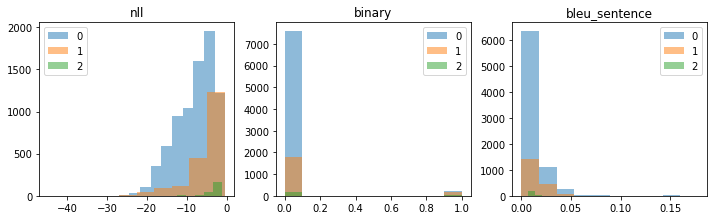

<function count_number_of_numbers at 0x128562378>


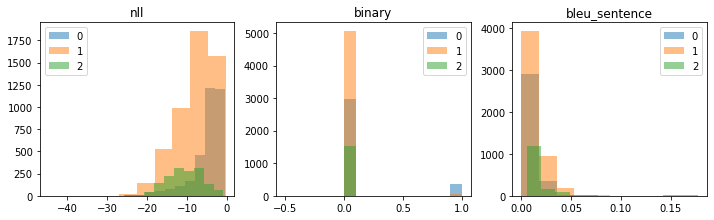

<function ratio_words_numbers at 0x129218f28>


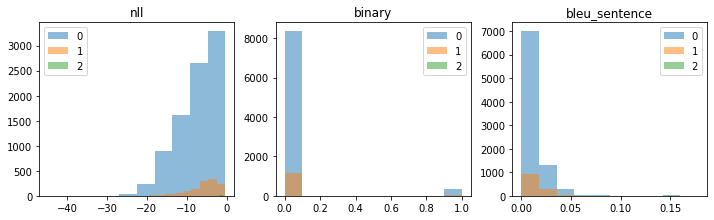

-----------------------------------------------
-----------------------------------------------
arithmetic__add_or_sub_big_src_test.txt
Number lengthts:  9.96035
Number of numbers:  2.0
Words/number ratio:  0.5572799690856511
Binary:  0.7744

<function count_numbers_length at 0x128562510>


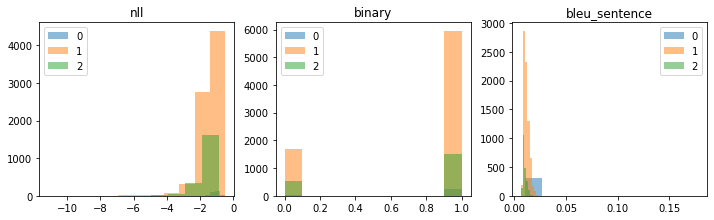

<function count_number_of_numbers at 0x128562378>


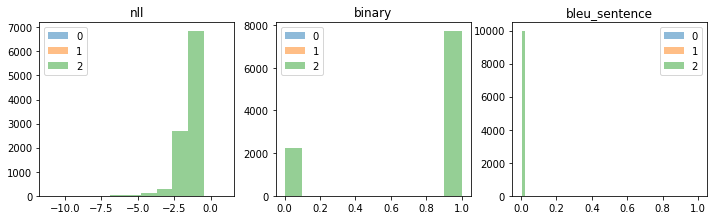

<function ratio_words_numbers at 0x129218f28>


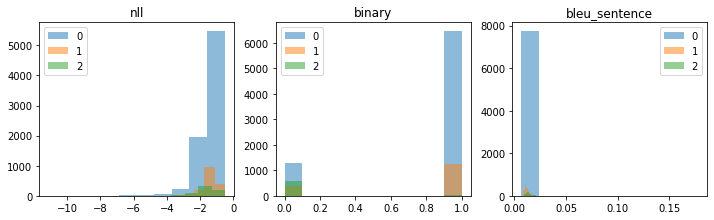

-----------------------------------------------
-----------------------------------------------
arithmetic__add_sub_multiple_longer_src_test.txt
Number lengthts:  1.9683419696969697
Number of numbers:  11.0053
Words/number ratio:  0.4789896409931509
Binary:  0.0125

<function count_numbers_length at 0x128562510>


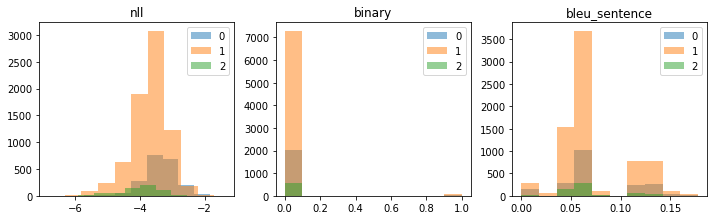

<function count_number_of_numbers at 0x128562378>


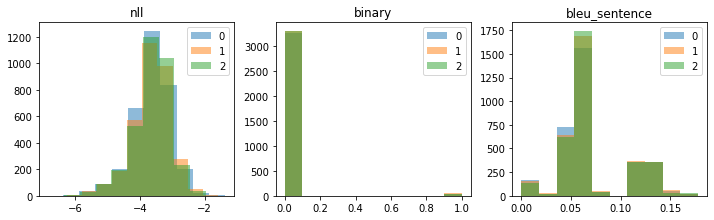

<function ratio_words_numbers at 0x129218f28>


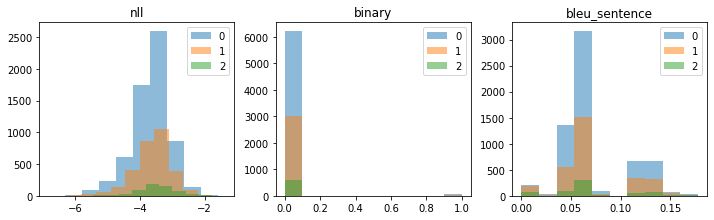

-----------------------------------------------
-----------------------------------------------
arithmetic__div_big_src_test.txt
Number lengthts:  7.00295
Number of numbers:  2.0
Words/number ratio:  1.0184090240962205
Binary:  0.5306

<function count_numbers_length at 0x128562510>


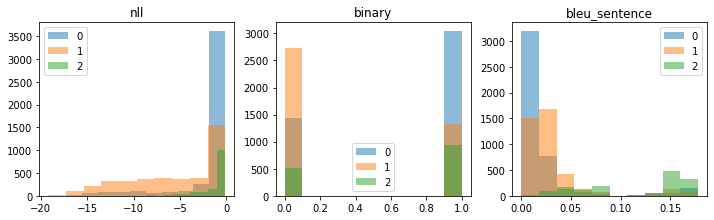

<function count_number_of_numbers at 0x128562378>


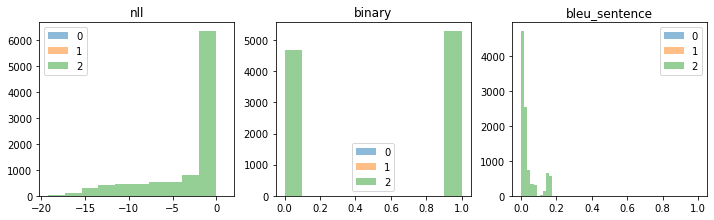

<function ratio_words_numbers at 0x129218f28>


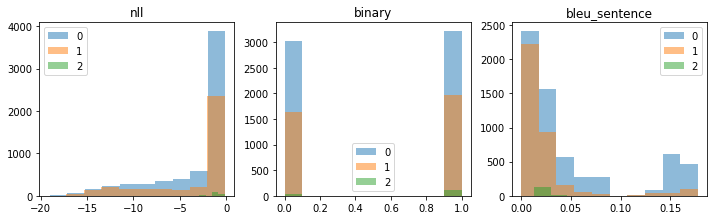

-----------------------------------------------
-----------------------------------------------
arithmetic__mixed_longer_src_test.txt
Number lengthts:  2.5201018181818187
Number of numbers:  10.9889
Words/number ratio:  0.3577696178567263
Binary:  0.0065

<function count_numbers_length at 0x128562510>


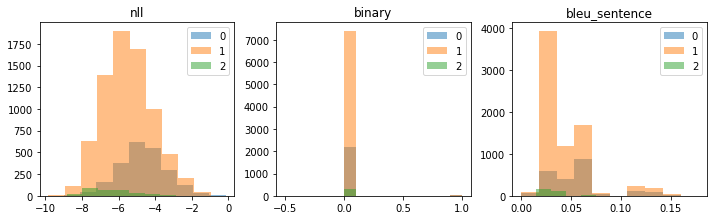

<function count_number_of_numbers at 0x128562378>


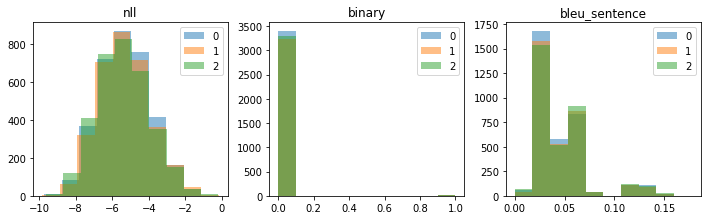

<function ratio_words_numbers at 0x129218f28>


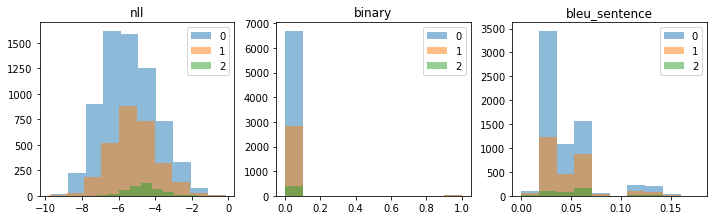

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_big_src_test.txt
Number lengthts:  6.56625
Number of numbers:  2.0
Words/number ratio:  0.7593945332445333
Binary:  0.3236

<function count_numbers_length at 0x128562510>


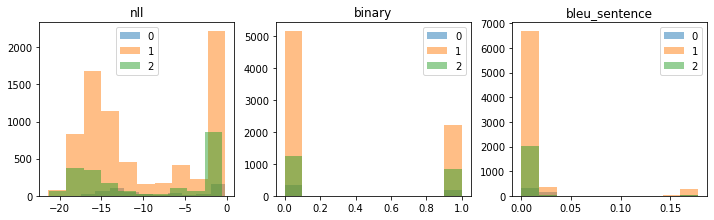

<function count_number_of_numbers at 0x128562378>


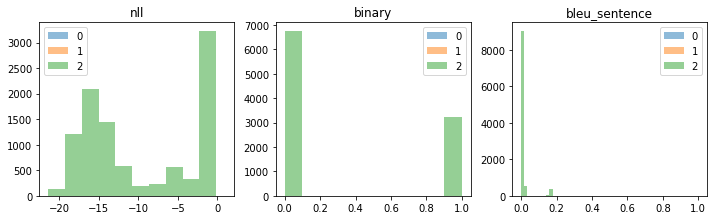

<function ratio_words_numbers at 0x129218f28>


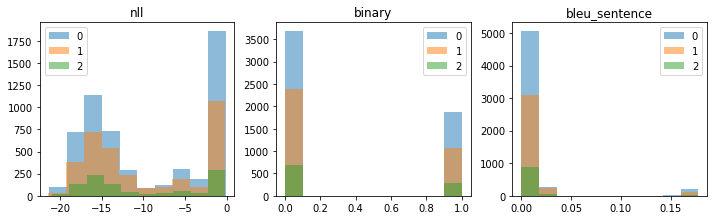

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_div_multiple_longer_src_test.txt
Number lengthts:  2.434530303030303
Number of numbers:  11.0183
Words/number ratio:  0.36959042661721403
Binary:  0.0261

<function count_numbers_length at 0x128562510>


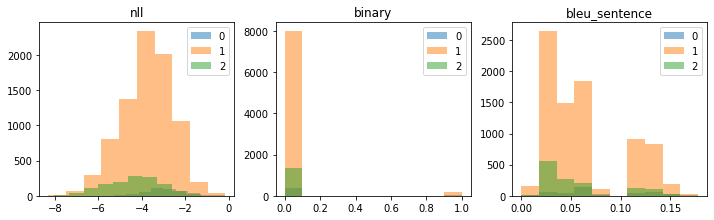

<function count_number_of_numbers at 0x128562378>


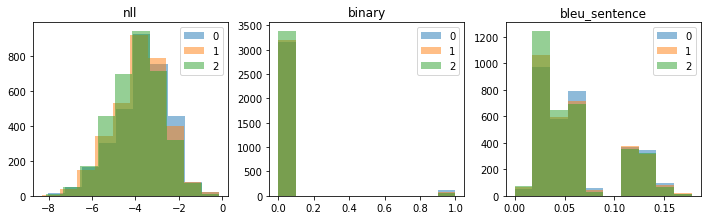

<function ratio_words_numbers at 0x129218f28>


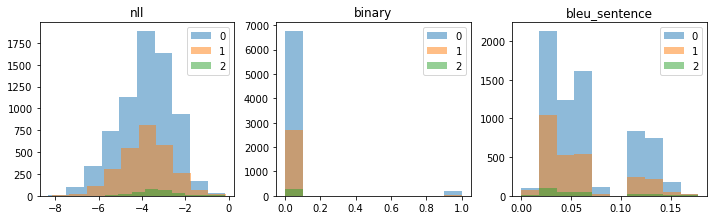

-----------------------------------------------
-----------------------------------------------
comparison__closest_more_src_test.txt
Number lengthts:  2.2819910482572983
Number of numbers:  10.727
Words/number ratio:  1.3217867366968532
Binary:  0.2994

<function count_numbers_length at 0x128562510>


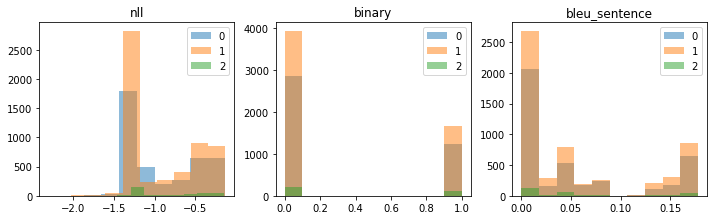

<function count_number_of_numbers at 0x128562378>


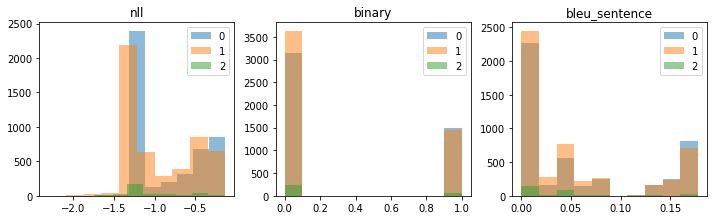

<function ratio_words_numbers at 0x129218f28>


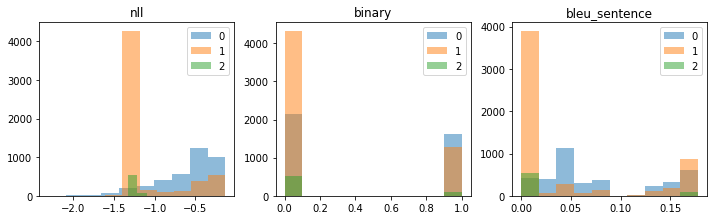

-----------------------------------------------
-----------------------------------------------
comparison__kth_biggest_more_src_test.txt
Number lengthts:  2.1956069331893597
Number of numbers:  12.0432
Words/number ratio:  1.7338295127341015
Binary:  0.1006

<function count_numbers_length at 0x128562510>


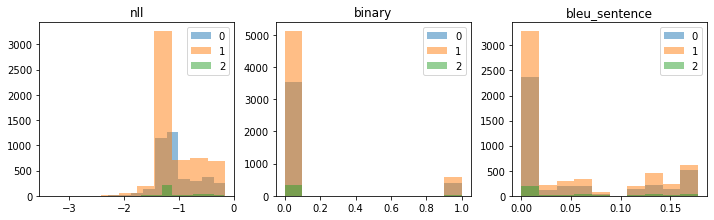

<function count_number_of_numbers at 0x128562378>


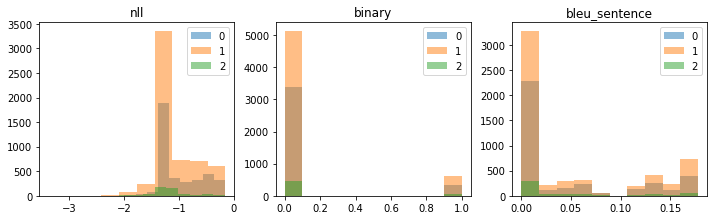

<function ratio_words_numbers at 0x129218f28>


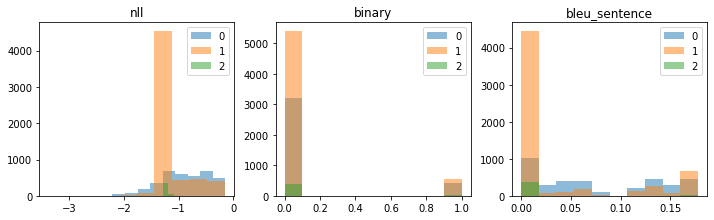

-----------------------------------------------
-----------------------------------------------
comparison__sort_more_src_test.txt
Number lengthts:  1.5303688888888891
Number of numbers:  9.0009
Words/number ratio:  1.5180260256410256
Binary:  0.48

<function count_numbers_length at 0x128562510>


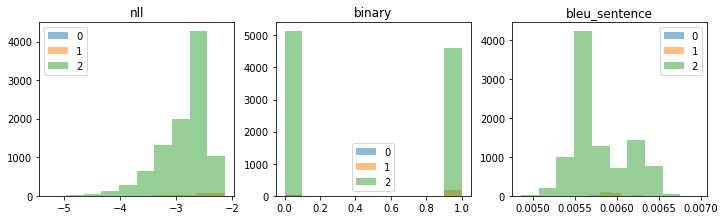

<function count_number_of_numbers at 0x128562378>


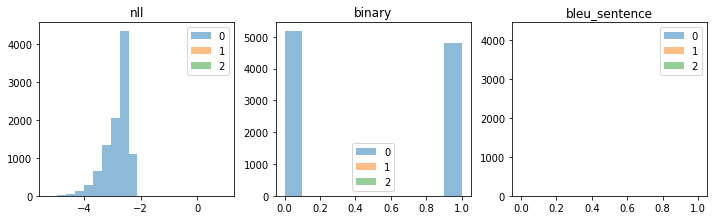

<function ratio_words_numbers at 0x129218f28>


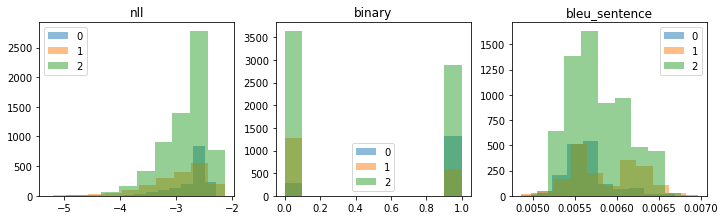

-----------------------------------------------
-----------------------------------------------
measurement__conversion_src_test.txt
Number lengthts:  10.0397
Number of numbers:  1.0
Words/number ratio:  2.8335952200577204
Binary:  0.0

<function count_numbers_length at 0x128562510>


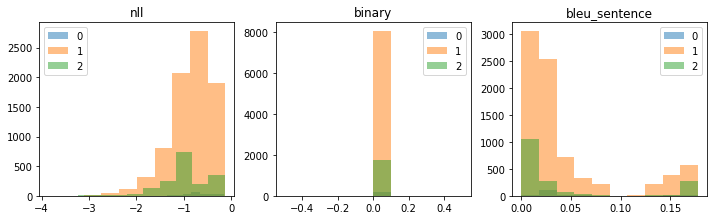

<function count_number_of_numbers at 0x128562378>


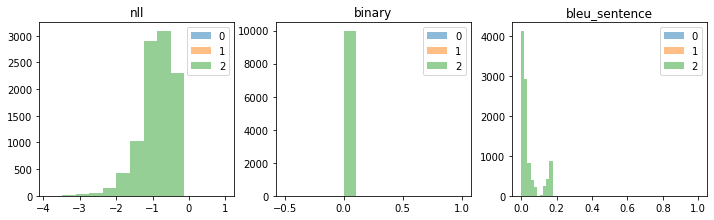

<function ratio_words_numbers at 0x129218f28>


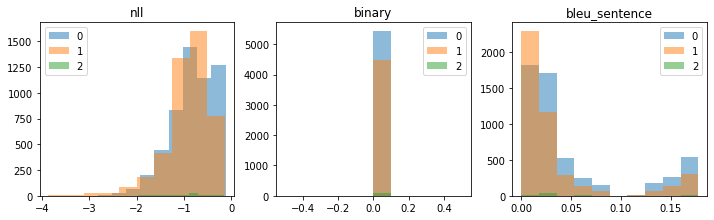

-----------------------------------------------
-----------------------------------------------
numbers__place_value_big_src_test.txt
Number lengthts:  11.8893
Number of numbers:  1.0
Words/number ratio:  2.1963368434343438
Binary:  0.4997

<function count_numbers_length at 0x128562510>


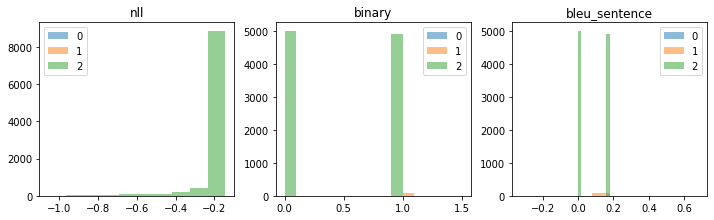

<function count_number_of_numbers at 0x128562378>


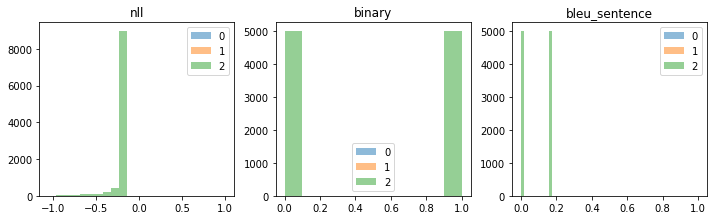

<function ratio_words_numbers at 0x129218f28>


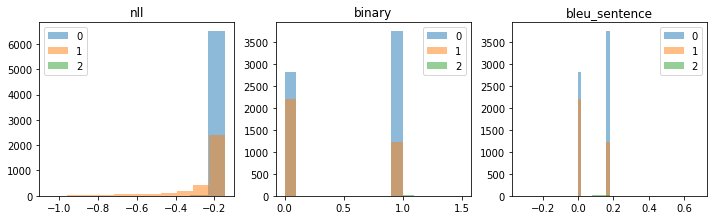

-----------------------------------------------
-----------------------------------------------
numbers__round_number_big_src_test.txt
Number lengthts:  11.644
Number of numbers:  1.4839
Words/number ratio:  1.6993409223443396
Binary:  0.879

<function count_numbers_length at 0x128562510>


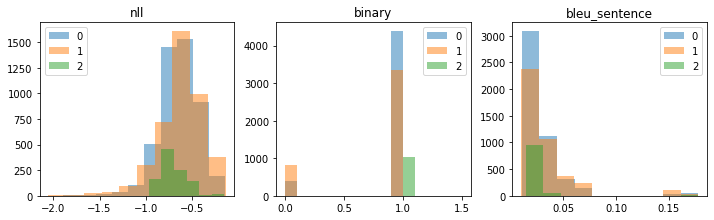

<function count_number_of_numbers at 0x128562378>


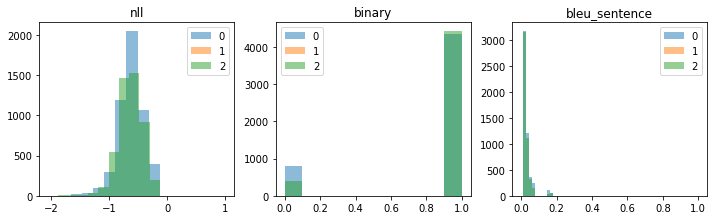

<function ratio_words_numbers at 0x129218f28>


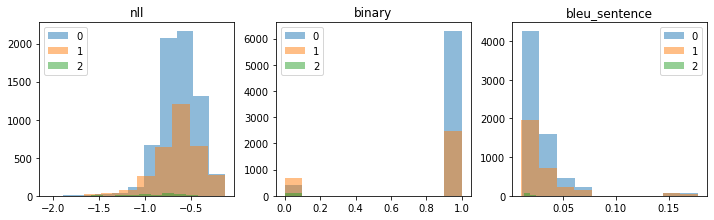

-----------------------------------------------
-----------------------------------------------
probability__swr_p_level_set_more_samples_src_test.txt
Number lengthts:  1.0269748448773448
Number of numbers:  4.2769
Words/number ratio:  25.070210295815293
Binary:  0.0006

<function count_numbers_length at 0x128562510>


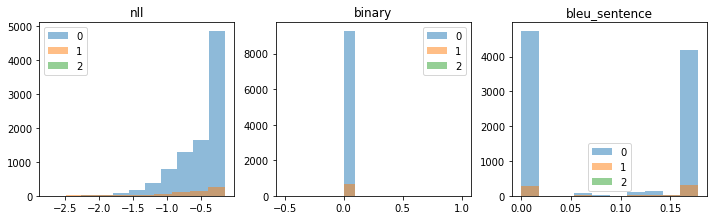

<function count_number_of_numbers at 0x128562378>


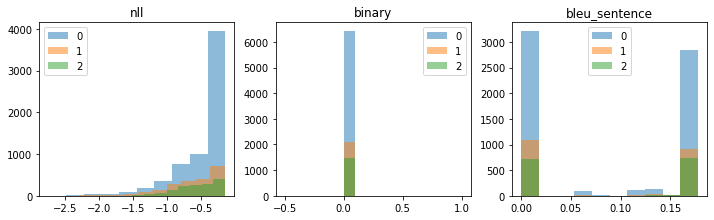

<function ratio_words_numbers at 0x129218f28>


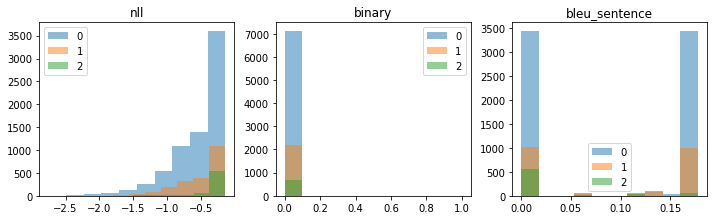

-----------------------------------------------
-----------------------------------------------
probability__swr_p_sequence_more_samples_src_test.txt
Number lengthts:  0.5380999999999999
Number of numbers:  1.8574
Words/number ratio:  10.20174880952381
Binary:  0.0115

<function count_numbers_length at 0x128562510>


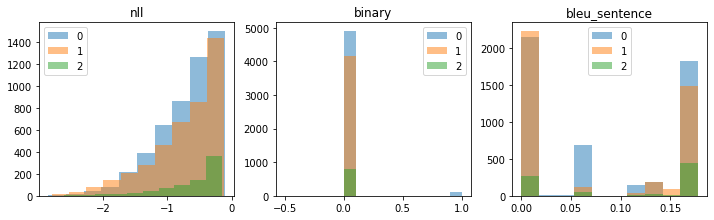

<function count_number_of_numbers at 0x128562378>


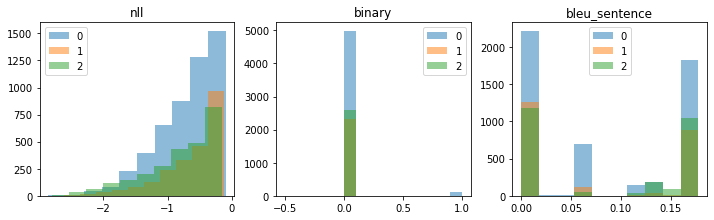

<function ratio_words_numbers at 0x129218f28>


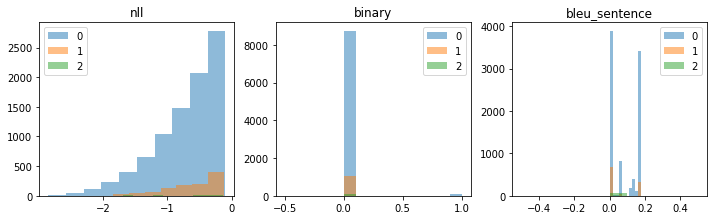

-----------------------------------------------

***********************
interpolate
***********************

-----------------------------------------------
algebra__polynomial_roots_src_test.txt
Number lengthts:  3.1163365279328517
Number of numbers:  8.1196
Words/number ratio:  0.6283470803728768
Binary:  0.1333

<function count_numbers_length at 0x128562510>


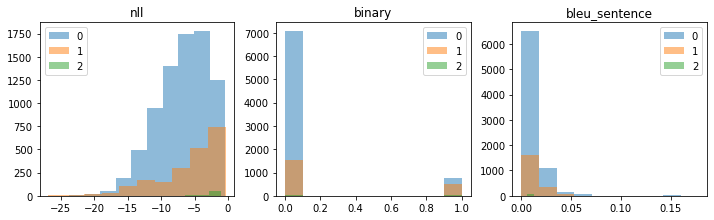

<function count_number_of_numbers at 0x128562378>


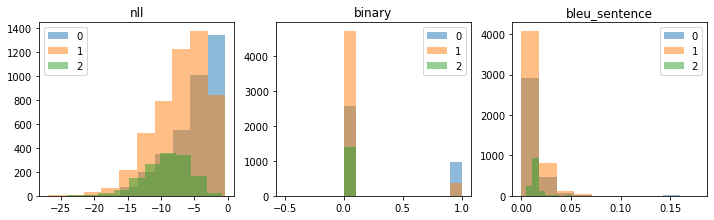

<function ratio_words_numbers at 0x129218f28>


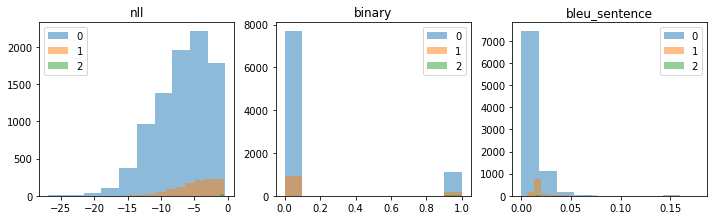

-----------------------------------------------
-----------------------------------------------
arithmetic__add_or_sub_src_test.txt
Number lengthts:  7.05825
Number of numbers:  2.0
Words/number ratio:  0.8217965401265401
Binary:  0.9332

<function count_numbers_length at 0x128562510>


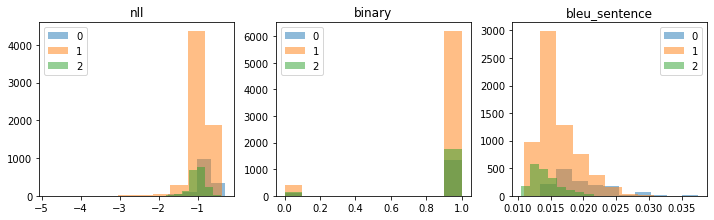

<function count_number_of_numbers at 0x128562378>


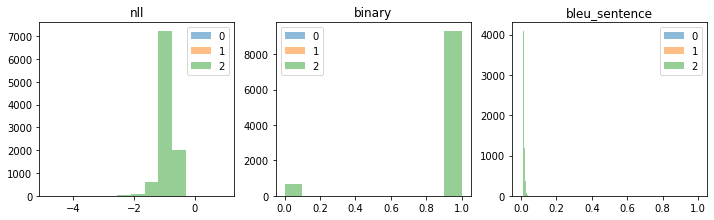

<function ratio_words_numbers at 0x129218f28>


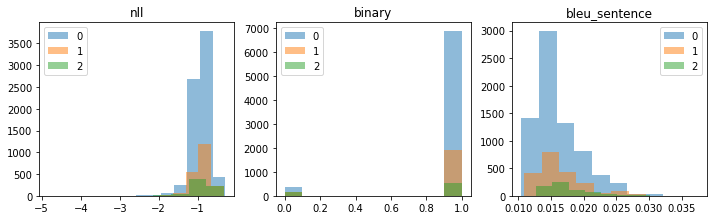

-----------------------------------------------
-----------------------------------------------
arithmetic__add_sub_multiple_src_test.txt
Number lengthts:  2.1482759523809523
Number of numbers:  5.5007
Words/number ratio:  0.9152499474136974
Binary:  0.0798

<function count_numbers_length at 0x128562510>


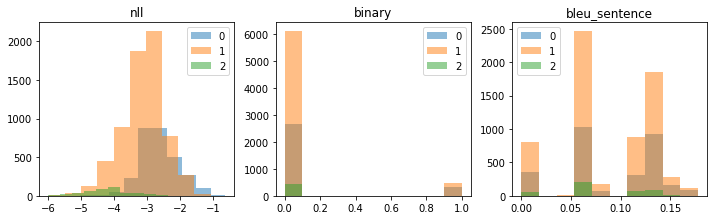

<function count_number_of_numbers at 0x128562378>


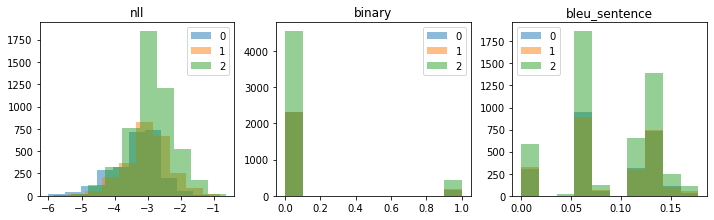

<function ratio_words_numbers at 0x129218f28>


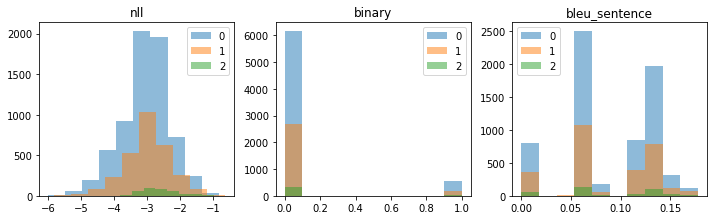

-----------------------------------------------
-----------------------------------------------
arithmetic__div_src_test.txt
Number lengthts:  5.12935
Number of numbers:  2.0
Words/number ratio:  1.424125429015429
Binary:  0.6799

<function count_numbers_length at 0x128562510>


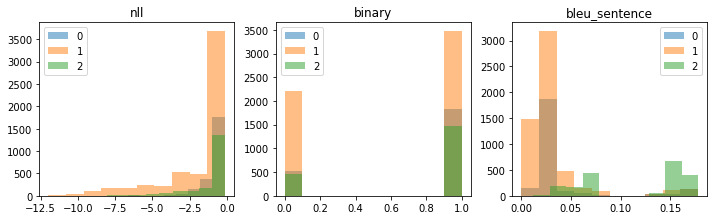

<function count_number_of_numbers at 0x128562378>


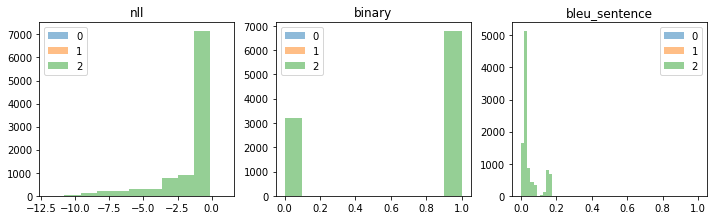

<function ratio_words_numbers at 0x129218f28>


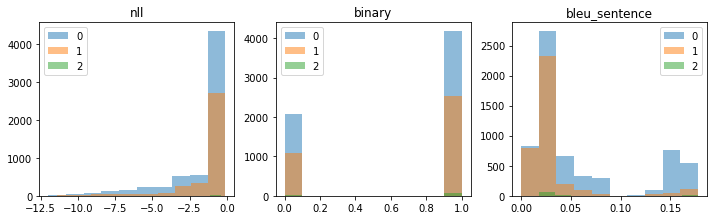

-----------------------------------------------
-----------------------------------------------
arithmetic__mixed_src_test.txt
Number lengthts:  2.8096735714285717
Number of numbers:  5.508
Words/number ratio:  0.6552483544615858
Binary:  0.1036

<function count_numbers_length at 0x128562510>


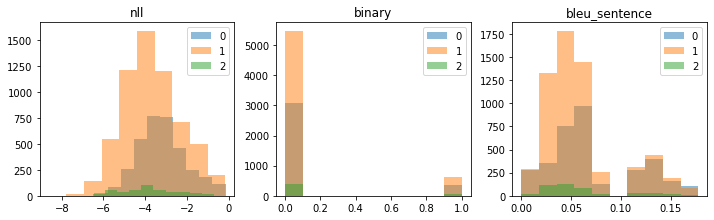

<function count_number_of_numbers at 0x128562378>


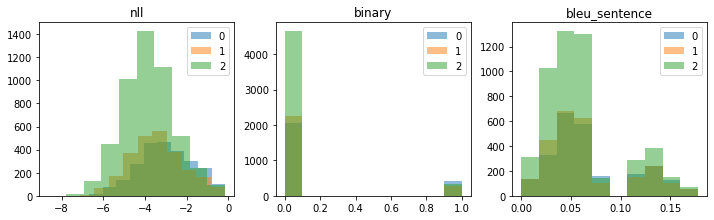

<function ratio_words_numbers at 0x129218f28>


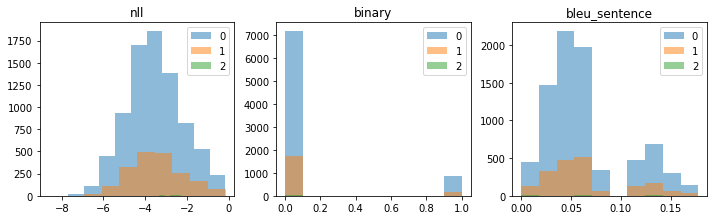

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_div_multiple_src_test.txt
Number lengthts:  2.743665
Number of numbers:  5.4925
Words/number ratio:  0.6660072892196383
Binary:  0.3647

<function count_numbers_length at 0x128562510>


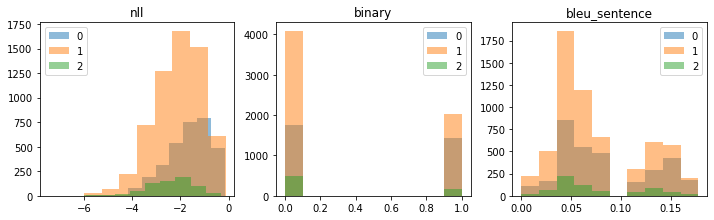

<function count_number_of_numbers at 0x128562378>


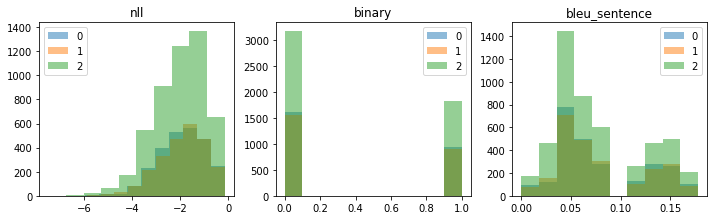

<function ratio_words_numbers at 0x129218f28>


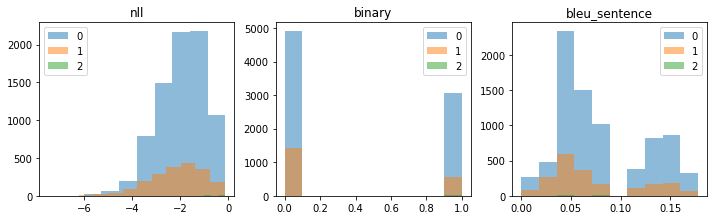

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_src_test.txt
Number lengthts:  5.12925
Number of numbers:  2.0
Words/number ratio:  1.0344311255411256
Binary:  0.4736

<function count_numbers_length at 0x128562510>


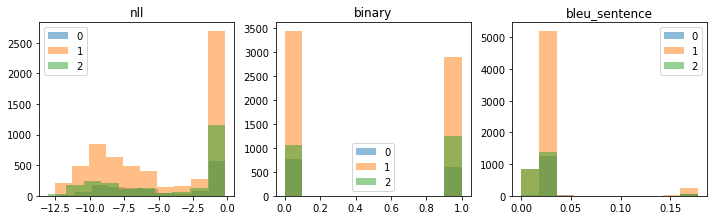

<function count_number_of_numbers at 0x128562378>


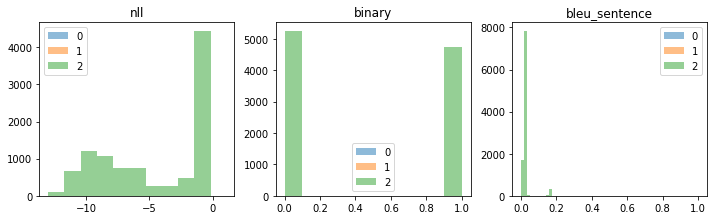

<function ratio_words_numbers at 0x129218f28>


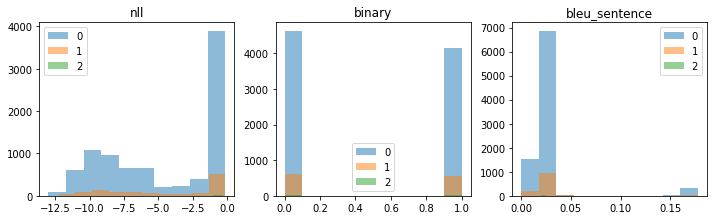

-----------------------------------------------
-----------------------------------------------
comparison__closest_src_test.txt
Number lengthts:  2.4166485137085134
Number of numbers:  6.2938
Words/number ratio:  1.9947098396701337
Binary:  0.571

<function count_numbers_length at 0x128562510>


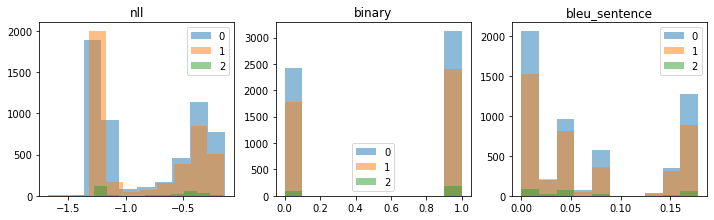

<function count_number_of_numbers at 0x128562378>


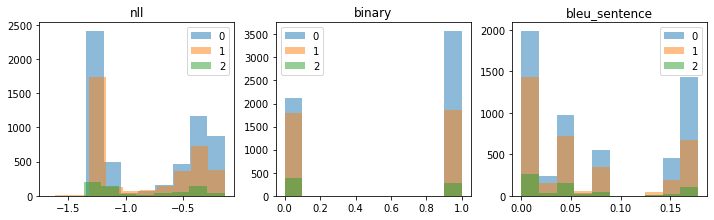

<function ratio_words_numbers at 0x129218f28>


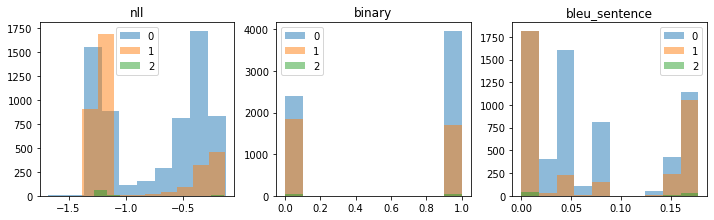

-----------------------------------------------
-----------------------------------------------
comparison__kth_biggest_src_test.txt
Number lengthts:  2.510907972860473
Number of numbers:  6.2663
Words/number ratio:  2.778442775131645
Binary:  0.2992

<function count_numbers_length at 0x128562510>


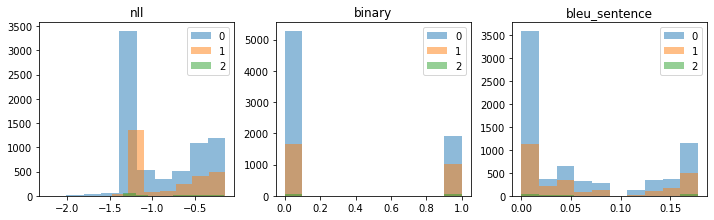

<function count_number_of_numbers at 0x128562378>


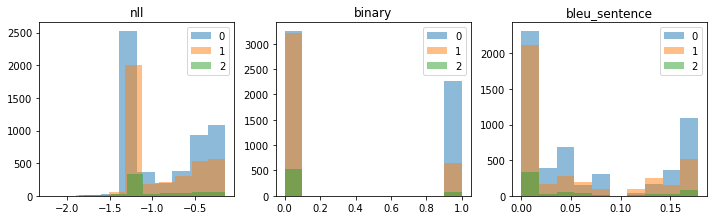

<function ratio_words_numbers at 0x129218f28>


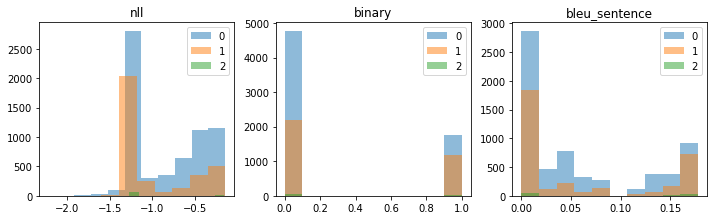

-----------------------------------------------
-----------------------------------------------
comparison__sort_src_test.txt
Number lengthts:  2.443104624819625
Number of numbers:  5.3026
Words/number ratio:  1.916740785048285
Binary:  0.9773

<function count_numbers_length at 0x128562510>


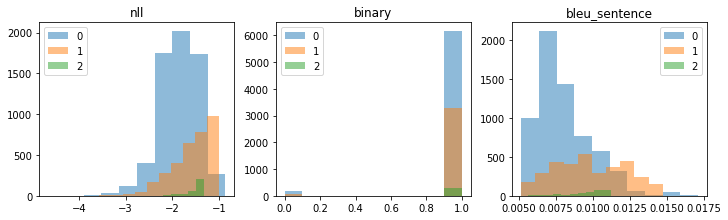

<function count_number_of_numbers at 0x128562378>


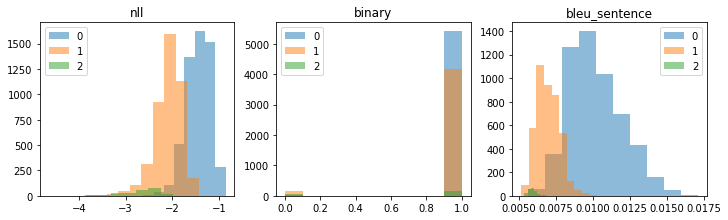

<function ratio_words_numbers at 0x129218f28>


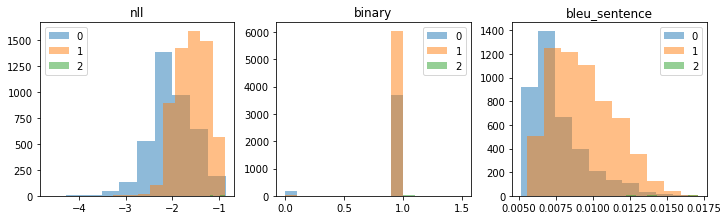

-----------------------------------------------
-----------------------------------------------
measurement__conversion_src_test.txt
Number lengthts:  4.4096
Number of numbers:  1.0336
Words/number ratio:  5.07116996031746
Binary:  0.0001

<function count_numbers_length at 0x128562510>


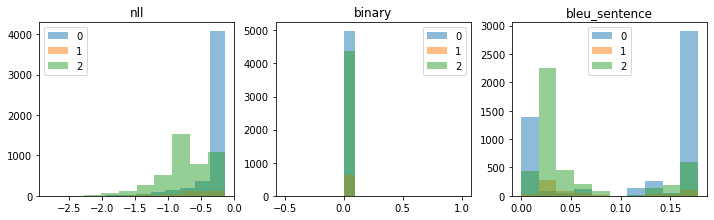

<function count_number_of_numbers at 0x128562378>


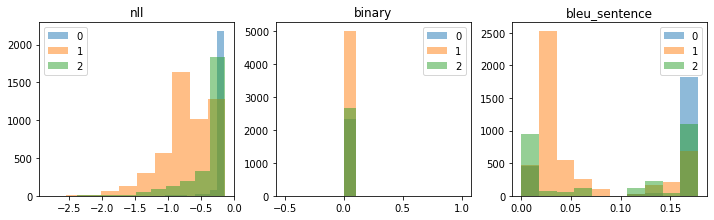

<function ratio_words_numbers at 0x129218f28>


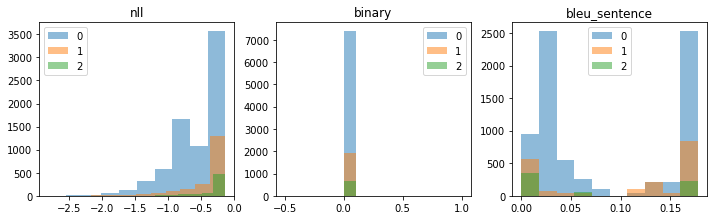

-----------------------------------------------
-----------------------------------------------
numbers__place_value_src_test.txt
Number lengthts:  7.8851
Number of numbers:  1.0
Words/number ratio:  3.1865203571428573
Binary:  1.0

<function count_numbers_length at 0x128562510>


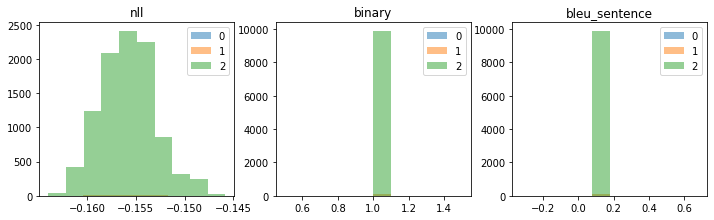

<function count_number_of_numbers at 0x128562378>


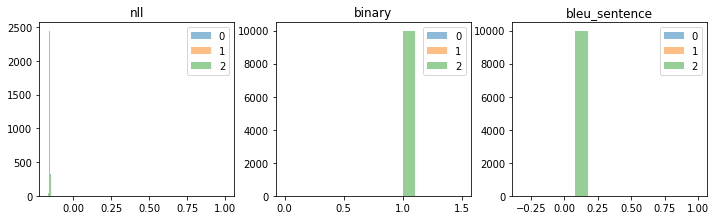

<function ratio_words_numbers at 0x129218f28>


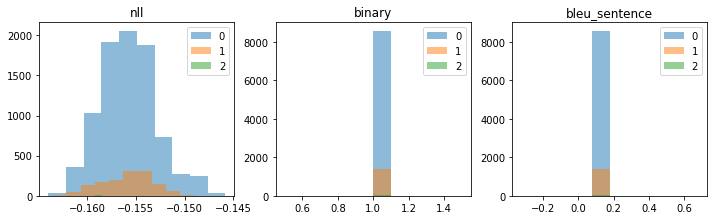

-----------------------------------------------
-----------------------------------------------
numbers__round_number_src_test.txt
Number lengthts:  8.77835
Number of numbers:  1.4875
Words/number ratio:  2.3581580199947108
Binary:  0.9562

<function count_numbers_length at 0x128562510>


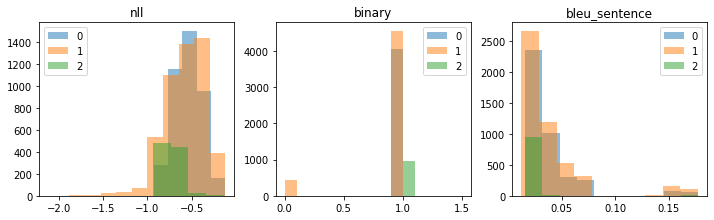

<function count_number_of_numbers at 0x128562378>


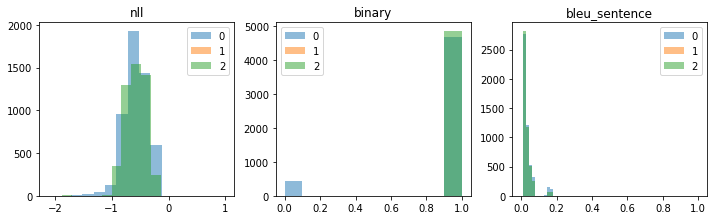

<function ratio_words_numbers at 0x129218f28>


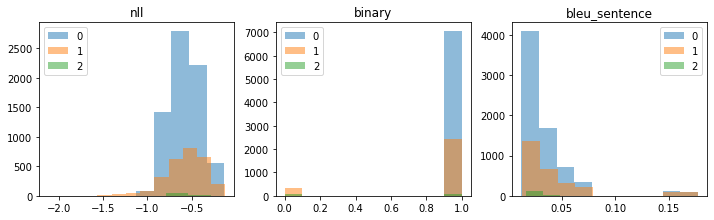

-----------------------------------------------
-----------------------------------------------
probability__swr_p_level_set_src_test.txt
Number lengthts:  1.022196984126984
Number of numbers:  4.0008
Words/number ratio:  28.581449592352094
Binary:  0.0003

<function count_numbers_length at 0x128562510>


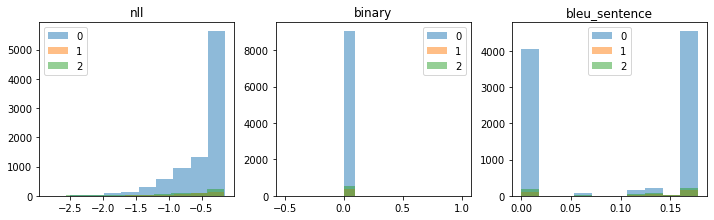

<function count_number_of_numbers at 0x128562378>


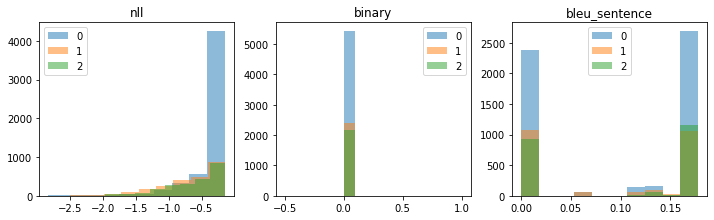

<function ratio_words_numbers at 0x129218f28>


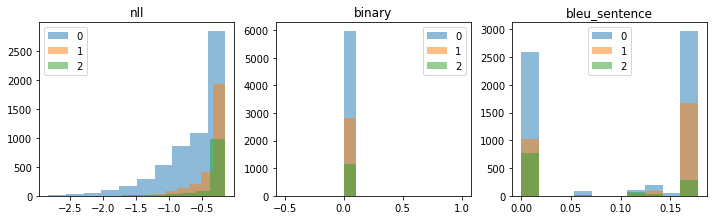

-----------------------------------------------
-----------------------------------------------
probability__swr_p_sequence_src_test.txt
Number lengthts:  0.53738
Number of numbers:  2.0706
Words/number ratio:  8.980572857142857
Binary:  0.0073

<function count_numbers_length at 0x128562510>


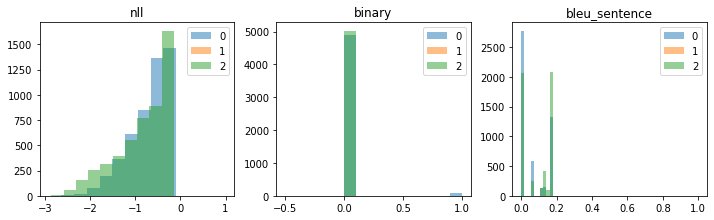

<function count_number_of_numbers at 0x128562378>


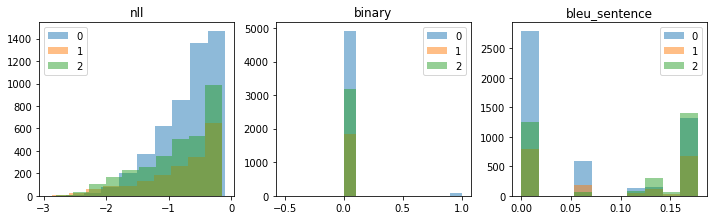

<function ratio_words_numbers at 0x129218f28>


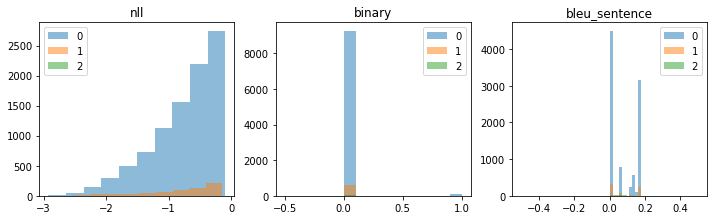

-----------------------------------------------


In [36]:
for targetid in targetids:
    print()
    print('***********************')
    print(targetid)
    print('***********************')
    print()
    for key in sorted(data[targetid].keys()):
        print('-----------------------------------------------')
        print(key)
        results = data[targetid][key]

        number_lengths = count_numbers_length(results)
        print('Number lengthts: ', number_lengths.mean())

        number_of_numbers = count_number_of_numbers(results)
        print('Number of numbers: ', number_of_numbers.mean())

        words_numbers_ratio = ratio_words_numbers(results)
        print('Words/number ratio: ', words_numbers_ratio.mean())

        binary_acc = compute_binary_accuracy(results)
        print('Binary: ', binary_acc.mean())

        print()
        compute_statistics(results, count_numbers_length)
        compute_statistics(results, count_number_of_numbers)
        compute_statistics(results, ratio_words_numbers)

        #sentence_acc = compute_bleu_sentence_accuracy(results)
        #print('Sentence: ', sentence_acc.mean())

        #corpus_acc = compute_bleu_sentence_accuracy(results)
        #print('Corpus: ', sentence_acc.mean())

        print('-----------------------------------------------')

In [37]:
# def 
# for key in sorted(tasks.keys()):
#     task_name, results = parse_file_results(tasks[key], targets[key])
#     print(task_name)
#     task_data = []
#     for r in results:
#         matches = re.findall(float_pattern, r.string)
#         #if i % int(5e5) == 0: print(matches)
#         lens = [len(match) for match in matches]
#         avg_len = sum(lens) / len(lens) if len(lens) > 0 else 0.
#         task_data.append([avg_len, r.prob])
#     print()
#     task_data= np.array(task_data)
    
#     fig, ax = plt.subplots()
#     n, bins, patches = ax.hist(task_data[:,0], 100)
#     plt.xlabel('length')
#     plt.show()
#     fig, ax = plt.subplots()
#     n, bins, patches = ax.hist(task_data[:,1], 100)
#     plt.xlabel('negative log likelihood')
#     plt.show()
    
#     #bins = np.linspace(task_data[:,0].min(), task_data[:,0].max(), 3)
#     #digitized = np.digitize(task_data[:,1], bins)
#     #bin_means = [task_data[digitized == i,1].mean() for i in range(1, len(bins))]
#     #print(bin_means)